In [1]:
import numpy as np
import random
import time
import os

In [2]:
def string2int(s):
    if s.isdigit():
        return int(s)
    elif s.startswith("-") and s[1:].isdigit():
        return -1*int(s[1:])
    else:
        return None

In [3]:
def file2cnf(f):
    cnf = []
    clause = []
    for line in f.readlines():
        line = line.strip()
        if not line.startswith("c") and not line.startswith("p"):
            lits = [string2int(var) for var in line.split(" ") if string2int(var)!=None]
            for l in lits:
                if l == 0:
                    if clause != []:
                        cnf.append(clause)
                        clause = []
                        continue
                    else:
                        clause = []
                        continue
                else:
                    clause.append(l)
    return cnf

In [4]:
def maxSAT(assignment, cnf):
    sat_clauses = 0
    for clause in cnf:
        for lit in clause:
            x = bool(assignment[abs(lit)-1])
            if (x and lit>0) or (not x and lit<0):
                sat_clauses += 1
                break
    return sat_clauses

In [5]:
def makePopulation(pop_size=120, num_genes=20):
    pop = []
    for i in range(pop_size):
        member = np.random.randint(0,2,size=num_genes)
        pop.append(member)
    return pop

In [6]:
def selection(population, cnf, percentage_pop=0.25):
    members_and_performance = []
    next_round = int(percentage_pop*len(population))
    best_perf = 0
    best_vars = None
    perf = 0
    for individual in population:
        performance = maxSAT(individual, cnf)
        pair = (individual, performance)
        members_and_performance.append(pair)
        perf+=performance
        if performance >= best_perf:
            best_perf = performance
            best_vars = individual

#     print(best_perf, best_vars, perf/len(population))
    nextGen = [mem for mem, perf in sorted(members_and_performance, reverse=True, key=lambda x: x[1])][:next_round]
    return nextGen

In [7]:
def uniformCrossover(population, pop_size=120, common_genes=0.5, pr_mutation=1.0):
    newPop = population
    while len(newPop)<pop_size:
        
        parent1_idx = random.randint(0,len(population)-1)
        parent2_idx = random.randint(0,len(population)-1)
        
        while parent1_idx == parent2_idx:
            parent1_idx = random.randint(0,len(population)-1)
            parent2_idx = random.randint(0,len(population)-1)
        
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]
        
        child = []
        
        for i in range(len(parent1)):
            if random.random() <= common_genes:
                child.append(parent1[i])
            else:
                child.append(parent2[i])

        if random.random() <= pr_mutation:
            mutation_idx = random.randint(0, len(child)-1)
            
            if child[mutation_idx] == 1:
                child[mutation_idx] = 0
                
            else:
                child[mutation_idx] = 1
        
        newPop.append(child)
        
    return newPop

In [8]:
def localSearchInnerLoop(assignment, cnf):
    unsatisfied = []
    for clause in cnf:
        evaluated = False
        for lit in clause:
            x = bool(assignment[abs(lit)-1])
            if (x and lit>0) or (not x and lit<0):
                evaluated = True
                break
        if not evaluated:
            unsatisfied.extend([abs(lit)-1 for lit in clause])
    random_flip = random.choice(unsatisfied)
    if assignment[random_flip]==1:
        assignment[random_flip]=0
    else:
        assignment[random_flip]=1
    return assignment

In [9]:
def satisfied(clause, assignment):
    for lit in clause:
        x = bool(assignment[abs(lit)-1])
        if (x and lit>0) or (not x and lit<0):
            return True
    return False

In [10]:
def allSatisfied(assignment, cnf):
    sat_clauses = 0
    for clause in cnf: 
        if not satisfied(clause, assignment):
            return False
    return True

In [11]:
def localSearch(population, cnf, iters=8000):
    newPop = []
    for assignment in population:
        if allSatisfied(assignment, cnf):
            return [assignment]
        for i in range(iters):
            assignment = localSearchInnerLoop(assignment, cnf)
            if allSatisfied(assignment, cnf):
                return [assignment]
        newPop.append(assignment)
    return newPop

In [12]:
def localSearchHC(population, cnf, iters=8000):
    newPop = []
    for assignment in population:
        perf = maxSAT(assignment, cnf)
        assignment = assignment
        if allSatisfied(assignment, cnf):
            return [assignment]
        for i in range(iters):
            new_assignment = localSearchInnerLoop(assignment, cnf)
            ms = maxSAT(new_assignment, cnf)
            if ms == len(cnf):
                return [assignment]
            elif ms >= perf:
                perf = ms
                assignment = new_assignment
        newPop.append(assignment)
    return newPop

In [15]:
def geneticAlgo(cnf, pop_size=24, gens=200, lsi=25, num_genes=100, search_local=False, hill_climb=False):
    max_gens = 0
    start = time.time()
    population = makePopulation(pop_size=pop_size, num_genes=num_genes)
    for i in range(gens):
        max_gens = i+1
        population = selection(population, cnf, percentage_pop=0.25)
        population = uniformCrossover(population, pop_size=pop_size, common_genes=0.5, pr_mutation=1)
        if search_local:
            if (i+1)%5==0:
                population = localSearch(population, cnf, lsi)
                if len(population)==1:
                    break
        if hill_climb:
            if (i+1)%5==0:
                population = localSearchHC(population, cnf, lsi)
                if len(population)==1:
                    break

    t = time.time()-start
    best_assignment = None
    best_performance = 0
    for assignment in population:
        performance = maxSAT(assignment, cnf)
        if performance >= best_performance:
            best_performance = performance
            best_assignment = assignment

    return max_gens, t, best_performance

In [ ]:
import os
path = 'cnfs/uf175-753'
files = os.listdir(path)
n_genes=175
time_list=[]
gen_list = []
perf_list = []
for file in files:
    f = open(path+'/'+file, "r")
    cnf = file2cnf(f)
    f.close()
    g, t, p = geneticAlgo(cnf,num_genes=n_genes, gens=150, hill_climb=True)
    time_list.append(t)
    gen_list.append(g)
    perf_list.append(p)
print(np.mean(time_list), np.mean(gen_list),np.mean(perf_list))

In [ ]:
time_list=[]
gen_list = []
perf_list = []
for file in files:
    f = open(path+'/'+file, "r")
    cnf = file2cnf(f)
    f.close()
    g, t, p = geneticAlgo(cnf,num_genes=n_genes, gens=150, search_local=True)
    time_list.append(t)
    gen_list.append(g)
    perf_list.append(p)
print(np.mean(time_list), np.mean(gen_list),np.mean(perf_list))

In [697]:
time_list=[]
gen_list = []
perf_list = []
for file in files:
    f = open(path+'/'+file, "r")
    cnf = file2cnf(f)
    f.close()
    g, t, p = geneticAlgo(cnf,num_genes=n_genes, gens=150)
    time_list.append(t)
    gen_list.append(g)
    perf_list.append(p)
print(np.mean(time_list), np.mean(gen_list),np.mean(perf_list))

1.1714184856414795 150.0 740.28


In [702]:
num_vars = [20,50,75,100,125,150,175]
num_clauses = [91,218,325,430,538,645,753]

hc_time = [0.03467469215, 1.300085244,3.549335899, 5.427012806,
           7.568920116,10.08174941,12.6621181]
hc_gens = [6.7,58,104,117.8,133,141.2,149.4]
hc_sat = [91,217.38,322.56,427.04,533.48,639.4,744.32]

ls_time = [0.02721810818,0.881681633,1.865428524,3.358934298,
           4.399652815,5.660552225,6.866606035]
ls_gens = [6.5,62.4,89.2,124.4,132.4,137.4,148.2]
ls_sat = [91,217.52,323.48,426.64,533.72,638.84,744.92]

gen_time = [0.1637220192,0.373471756,0.5621363449,0.6701219559,
            0.8502110672,1.005866175,1.171418486]
gen_gens = [150,150,150,150,150,150,150]
gen_sat = [90.36,215.7,320.44,423.4,531,635.52,740.28]


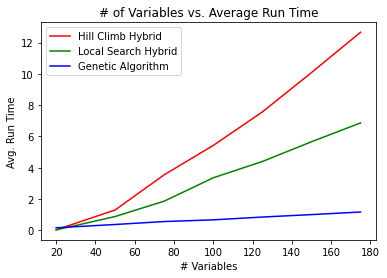

In [704]:
import matplotlib.pyplot as plt

plt.title("# of Variables vs. Average Run Time")
plt.xlabel("# Variables")
plt.ylabel("Avg. Run Time")
plt.plot(num_vars, hc_time, color='red')
plt.plot(num_vars, ls_time, color='green')
plt.plot(num_vars, gen_time, color='blue')
plt.legend(["Hill Climb Hybrid", "Local Search Hybrid", "Genetic Algorithm"])
plt.show()


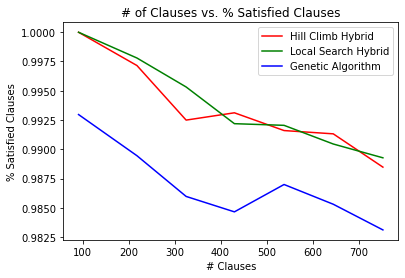

In [708]:
plt.title("# of Clauses vs. % Satisfied Clauses")
plt.xlabel("# Clauses")
plt.ylabel("% Satisfied Clauses")
plt.plot(num_clauses, np.divide(hc_sat,num_clauses), color='red')
plt.plot(num_clauses, np.divide(ls_sat,num_clauses), color='green')
plt.plot(num_clauses, np.divide(gen_sat,num_clauses), color='blue')
plt.legend(["Hill Climb Hybrid", "Local Search Hybrid", "Genetic Algorithm"])
plt.show()


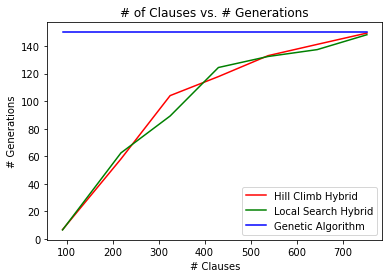

In [710]:
plt.title("# of Clauses vs. # Generations")
plt.xlabel("# Clauses")
plt.ylabel("# Generations")
plt.plot(num_clauses, hc_gens, color='red')
plt.plot(num_clauses, ls_gens, color='green')
plt.plot(num_clauses, gen_gens, color='blue')
plt.legend(["Hill Climb Hybrid", "Local Search Hybrid", "Genetic Algorithm"])
plt.show()
